# VRP by learning from historical data

In the Vehicle Routing Problem (VRP), the goal is to find a closed path of minimal length   
for a fleet of vehicles visiting a set of locations.  
If there is only ***one*** vehicle, the problem reduces to the TSP.  

In this example, we will:

1. Show how CPMpy can be used to solve a given VRP instance
2. Create historical instances
3. Simulate the hidden preferences of a route planner
4. Using (3), compute the user-preferred routing for each instance
5. Learn/train a model from the user-preferred routings ("historical data")
6. Apply learned model to a chosen test instance 
7. Visualize and compare model prediction against user-preferred and distance-based solution

In [1]:
# import libraries

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon

from cpmpy import *

### CPMpy VRP Model

In [2]:
def solve_vrp(stops, distance_matrix, n_vehicle, q):
    
    n_city = len(stops)

    demand = [1 for i in range(len(stops))]
    
    x = intvar(0, 1, shape=distance_matrix.shape)   # x[i,j] = 1 means that a vehicle goes from node i to node j 
    y = intvar(0, q, shape=distance_matrix.shape)   # y[i,j] is a flow of load through arc (i,j)
    
    model = Model(
        sum(x[0,:]) == n_vehicle,                   # constraint on number of vehicles (from depot)
         
        [sum(x[i,:])==1 for i in range(1,n_city)],  # vehicle leaves and enter each node i exactly once
        [sum(x[:,i])==1 for i in range(1,n_city)],
        
        [sum(x[i,i] for i in range(n_city))==0],    # no self visits

        # from depot takes no load
        sum(y[0,:]) == 0,
        # flow out of node i through all outgoing arcs is equal to 
        # flow into node i through all ingoing arcs + load capacity @ node i
        [sum(y[i,:])==sum(y[:,i])+demand[i] for i in range(1,n_city)],
    )
    
    # capacity constraint at each node (conditional on visit)
    for i in range(n_city):
        for j in range(n_city):
            model += y[i,j] <= q*x[i,j]
            
    # the objective is to minimze the travelled distance 
    # sum(x*dist) does not work because 2D array, use .sum()
    model.minimize((x*distance_matrix).sum())
    
    model.solve()
    
    sol = x.value()
        
    return sol

### Example solution for one VRP instance

In [3]:
# x and y coordinates of one instance
inst_stops  = [ 0,  1,  2,  3,  4,  5,  6,  7,  8] 
inst_x      = [35, 55, 15, 25, 10, 41, 15, 30, 10]
inst_y      = [35, 45, 30, 30, 43, 49, 10, 25, 20]

dist_matrix = np.hypot(np.array([inst_x])-np.array([inst_x]).T, np.array([inst_y])-np.array([inst_y]).T).astype(int)

inst_sol = solve_vrp(inst_stops, dist_matrix, 3, 3)
print("Solution as a Boolean matrix:\n\n", inst_sol)

def route_tolist(stops, sol):    
    firsts = np.where(sol[0]==1)[0]
    routing = []
    for i in range(len(firsts)):
        temp_route = [0, firsts[i]]
        while temp_route[-1] != 0:
            temp_route.append(np.where(sol[temp_route[-1]]==1)[0][0])
        route = [stops[k] for k in temp_route]
        routing.append(route)
    return routing

print("\nSolution converted to a routing: ", route_tolist(inst_stops, inst_sol))

Solution as a Boolean matrix:

 [[0 0 0 1 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0]]

Solution converted to a routing:  [[0, 3, 2, 4, 0], [0, 5, 1, 0], [0, 7, 6, 8, 0]]


### Visualization of preferences

Entire delivery area is divided into three cities; planner preference is to assign one vehicle per city.

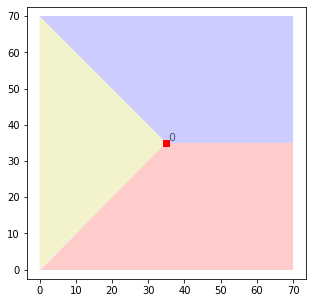

In [4]:
def plot_routing(routing_to_map, instance_num, hist_stops, full_x, full_y):
    
    y1 = np.array([[0,0], [0,70], [35,35]])
    y2 = np.array([[35,35], [0,70], [70,70], [70,35]])
    y3 = np.array([[35,35], [70,35], [70,0], [0,0]])
    p1 = Polygon(y1, facecolor = 'y', alpha = 0.2)
    p2 = Polygon(y2, facecolor = 'b', alpha = 0.2)
    p3 = Polygon(y3, facecolor = 'r', alpha = 0.2 )
    plt.gca().add_patch(p1)
    plt.gca().add_patch(p2)
    plt.gca().add_patch(p3)

    style = 'Simple, tail_width=0.5, head_width=10, head_length=6'
    loc_x = []
    loc_y = []
    for i in range(len(hist_stops[instance_num])):
        loc_x.append(full_x[hist_stops[instance_num][i]])
        loc_y.append(full_y[hist_stops[instance_num][i]])

    plt.scatter(loc_x[1:], loc_y[1:])

    for route in routing_to_map:
        for i in range(len(route)-1):
            m = list(hist_stops[instance_num]).index(route[i])
            n = list(hist_stops[instance_num]).index(route[i+1])
            plt.gca().add_patch(patches.FancyArrowPatch((loc_x[m], loc_y[m]), (loc_x[n], loc_y[n]), 
                    connectionstyle="arc3,rad=0.1", arrowstyle=style, color='gray', alpha=0.8))
    for i in range(len(hist_stops[instance_num])):
        plt.annotate(hist_stops[instance_num][i], (loc_x[i]+0.5, loc_y[i]+0.5), fontsize=11, alpha=0.6)
        # show depot (red square)
    plt.plot(loc_x[0], loc_y[0], c = 'r', marker = 's')
    plt.axis('equal');
    
plt.figure(figsize=(5,5))
plot_routing([[0]], 0, [[0]] , [35], [35])

### Data generation

In [5]:
# x and y coordinates of all available stops
full_x = [35, 41, 35, 55, 55, 15, 25, 20, 10, 55, 30, 20, 50, 30, 15, 30, 10]
full_y = [35, 49, 17, 45, 20, 30, 30, 50, 43, 60, 60, 65, 35, 25, 10,  5, 20]

# generate hist_length instances for training and testing by sampling from all available stops
# each instance is of length num_of_stops
# Gaussian sampling is used to simulate real-life situations where companies have both regular and irregular clients

hist_length = 150
num_of_stops = 8

hist_stops = []
random.seed(1)
for i in range(hist_length):
    init_list = []
    while len(init_list) < num_of_stops:
        sample = int(random.gauss(len(full_x)/2, len(full_x)/4))
        if sample > 0 and sample < len(full_x) and sample not in init_list:
            init_list.append(sample)
    init_list.insert(0,0)
    hist_stops.append(init_list)

hist_stops[:5]

[[0, 13, 14, 8, 5, 3, 4, 2, 9],
 [0, 9, 10, 4, 8, 2, 7, 13, 12],
 [0, 6, 9, 12, 11, 3, 10, 8, 13],
 [0, 8, 9, 11, 3, 6, 16, 7, 1],
 [0, 12, 6, 11, 2, 13, 14, 8, 9]]

### Computing for user-preferred solutions

This step will create the historical data; data will be used to train the model.

In [6]:
# create full distance matrix
# distance matrix is needed to compute for pure distance (traditional software) solution

full_dist_mat = np.hypot(np.array([full_x])-np.array([full_x]).T, np.array([full_y])-np.array([full_y]).T)
        
# create full preference matrix
# the goal of this step is to simulate the "hidden" preferences of the route planners

full_pref_mat = np.empty((len(full_dist_mat), len(full_dist_mat)))
for i in range(len(full_pref_mat)):
    for j in range(len(full_pref_mat)):
        if any([
        all([full_y[i]>=35, full_y[j]>=35, full_y[i]>=-full_x[i]+70, full_y[j]>=-full_x[j]+70]), # city 1
        all([full_y[i]>=full_x[i], full_y[j]>=full_x[j], full_y[i]<=-full_x[i]+70, full_y[j]<=-full_x[j]+70]), # city 2
        all([full_y[i]<=35, full_y[j]<=35, full_y[i]<=full_x[i], full_y[j]<=full_x[j]])  # city 3
        ]): 
            full_pref_mat[i][j] = 0.5*np.hypot(full_x[i]-full_x[j], full_y[i]-full_y[j])
        else:
            full_pref_mat[i][j] = 1.5*np.hypot(full_x[i]-full_x[j], full_y[i]-full_y[j])
            
# compute for preferred solutions with added counterclockwise preference
# planner preference is to have one vehicle/route per city, 
# and also for the routes to be in a counterclockwise direction

pref_sols_temp = []
for i in range(len(hist_stops)):
    print("User-preferred solution. Solving instance", i, end="\r")
    pref_inst_sol = solve_vrp(hist_stops[i], full_pref_mat[np.ix_(hist_stops[i], hist_stops[i])].astype(int), 3, 3)
    pref_sols_temp.append([route_tolist(hist_stops[i], pref_inst_sol), pref_inst_sol])
print("User-preferred solutions solved.")
    
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

# add counterclockwise preference
pref_sols = []
for i in range(len(pref_sols_temp)):
    current_routing = pref_sols_temp[i][0]
    rev_routing = []
    for route in current_routing:
        entry_pt = (full_x[route[1]]-35, full_y[route[1]]-35)
        exit_pt = (full_x[route[-2]]-35, full_y[route[-2]]-35)
        if angle_between(entry_pt, exit_pt) < angle_between(exit_pt, entry_pt) :
            route = route[::-1]
        rev_routing.append(route)
    pref_sols.append(rev_routing)
    
pref_sols[:5]

User-preferred solutions solved. instance 149 27 108


[[[0, 14, 2, 4, 0], [0, 8, 5, 13, 0], [0, 3, 9, 0]],
 [[0, 4, 12, 9, 0], [0, 10, 7, 8, 0], [0, 13, 2, 0]],
 [[0, 12, 3, 9, 0], [0, 10, 11, 0], [0, 8, 6, 13, 0]],
 [[0, 11, 7, 8, 0], [0, 6, 16, 0], [0, 3, 9, 1, 0]],
 [[0, 12, 9, 11, 0], [0, 13, 14, 2, 0], [0, 8, 6, 0]]]

### Learning from historical data

Markovian approach: learn transition probability matrix from historical solutions  
then use matrix to find the maximum likelihood routing.

In [7]:
def flatten(something):
    if isinstance(something, (list, tuple, set, range)):
        for sub in something:
            yield from flatten(sub)
    else:
        yield something
        
def create_pmatrix(num_of_allstops, historical_solutions, test_inst_stops):
    
    # num_of_allstops includes depot
    mat_dim = num_of_allstops
    freq_matrix = np.zeros((mat_dim, mat_dim))

    for (i, data_inst) in enumerate(historical_solutions):
        
        weight = 1 # uniform weights

        for route in data_inst:
            for i in range(len(route)-1):
                freq_matrix[route[i]][route[i+1]] += weight

    proba_matrix = freq_matrix[np.ix_(test_inst_stops, test_inst_stops)]
    proba_matrix = proba_matrix + 1 # smoothing
    proba_matrix = proba_matrix/proba_matrix.sum(axis=-1,keepdims=True) # normalization
    proba_matrix = -np.log(proba_matrix) # take negative logarithm
    
    return proba_matrix

### Evaluation/Testing

Here, we first select a test instance.  
A model will be trained using all *previous* instances.  
Test instance will be solved using trained model.

In [8]:
# mixing_parameter takes a value between [0,1]
# measure of how much to weight distances versus preferences
# choose 0 to get pure distance solutions; 1 for pure preferences

mixing_parameter = 0.2

# choose an instance between 130 to 149 to have sufficient data for training

test_inst = 141

In [9]:
arc_proba_mat = create_pmatrix(len(full_x), pref_sols[:test_inst], hist_stops[test_inst])

dist_proba_mat = full_dist_mat[np.ix_(hist_stops[test_inst], hist_stops[test_inst])] 
dist_proba_mat = dist_proba_mat/dist_proba_mat.sum(axis=1, keepdims=1)
dist_proba_mat = 1/dist_proba_mat
dist_proba_mat[~np.isfinite(dist_proba_mat)] = 0
dist_proba_mat = dist_proba_mat/dist_proba_mat.sum(axis=1, keepdims=1)
dist_proba_mat = -np.log(dist_proba_mat)
dist_proba_mat[dist_proba_mat==np.inf] = 0
dist_proba_mat[dist_proba_mat==0] = 2*np.max(dist_proba_mat)

mixed_mat = (100*(mixing_parameter*arc_proba_mat + (1-mixing_parameter)*dist_proba_mat)).astype(int)

test_sol = solve_vrp(hist_stops[test_inst], mixed_mat, 3, 3)

C:\Users\rocs_\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\rocs_\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


### Visualization and comparison of results

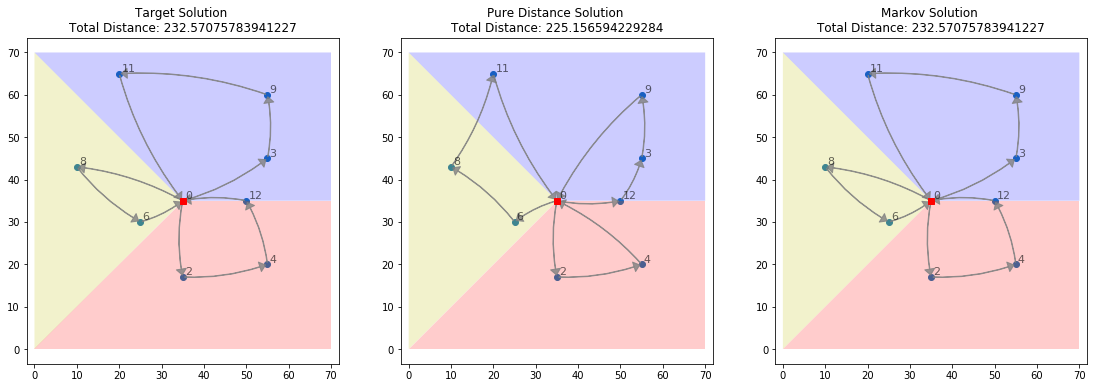

In [10]:
dist_sol = solve_vrp(hist_stops[test_inst], 
                     full_dist_mat[np.ix_(hist_stops[test_inst], hist_stops[test_inst])].astype(int), 3, 3)

plt.figure(figsize=(19,6))

# sp1
plt.subplot(131).set_title(f"Target Solution \n"
            f"Total Distance: {(pref_sols_temp[test_inst][1]*full_dist_mat[np.ix_(hist_stops[test_inst], hist_stops[test_inst])]).sum()}")
plot_routing(pref_sols[test_inst], test_inst, hist_stops, full_x, full_y)

# sp2
plt.subplot(132).set_title(f"Pure Distance Solution \n"
            f"Total Distance: {(dist_sol*full_dist_mat[np.ix_(hist_stops[test_inst], hist_stops[test_inst])]).sum()}")
plot_routing(route_tolist(hist_stops[test_inst], dist_sol), test_inst, hist_stops, full_x, full_y)

# sp3
plt.subplot(133).set_title(f"Markov Solution \n"
            f"Total Distance: {(test_sol*full_dist_mat[np.ix_(hist_stops[test_inst], hist_stops[test_inst])]).sum()}")
plot_routing(route_tolist(hist_stops[test_inst], test_sol), test_inst, hist_stops, full_x, full_y)